In [3]:
import numpy as np
import random
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

In [5]:
# データの読み込み
df = pd.read_csv('./data/ks-projects-201801.csv')
print("Shape:", df.shape)
df.head()

Shape: (378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [70]:
# 学習用データとテスト用データに分割
np.random.seed(seed=14)
idx = df.index.values
train_len = int(df.shape[0] * 0.8)

# 学習用データ
train_idx = random.sample(list(idx), train_len)
train_df = df.iloc[train_idx,:]
# テスト用データ
test_idx = list(set(df.index.values) ^ set(train_idx))
test_df = df.iloc[test_idx, :]
print(train_df.shape, test_df.shape)
print('{} + {} = {}: {}'.format(train_df.shape[0], test_df.shape[0], train_df.shape[0]+test_df.shape[0], df.shape[0]))

(302928, 15) (75733, 15)
302928 + 75733 = 378661: 378661


failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


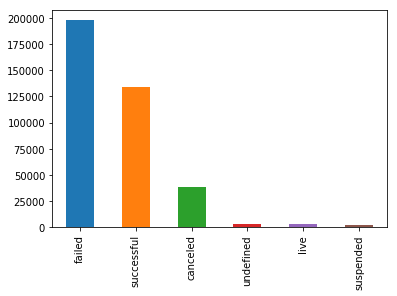

In [10]:
# stateのユニーク
y = df.state
print(y.value_counts())
y.value_counts().plot.bar()

In [11]:
# yをtrue/falseに変換
y_bool = y == 'successful'
y_bool.value_counts()

False    244705
True     133956
Name: state, dtype: int64

## 可視化

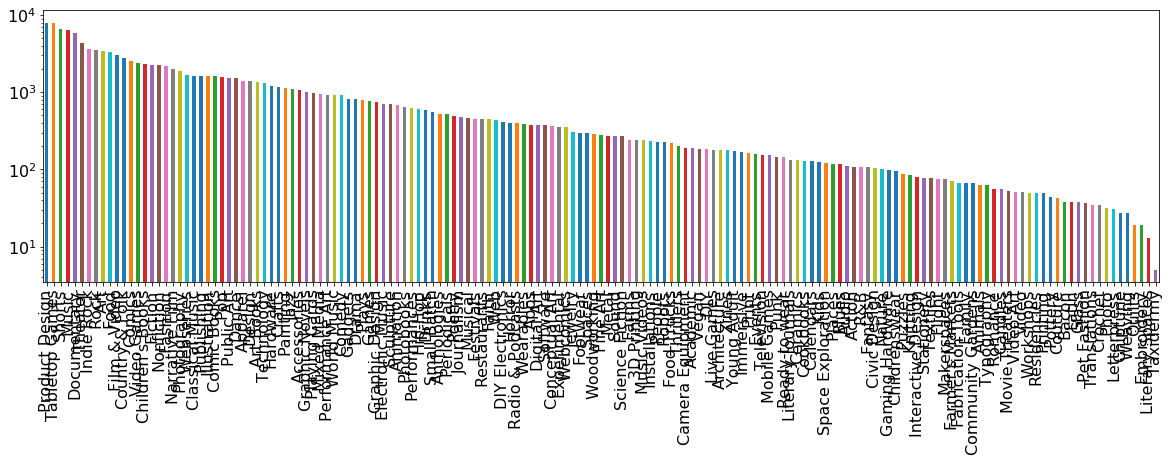

In [16]:
# 成功のカテゴリの分布
df_true_category = df.category[true_id]
df_true_category.value_counts().plot(kind='bar', figsize=(20,5), fontsize=16, logy=True)

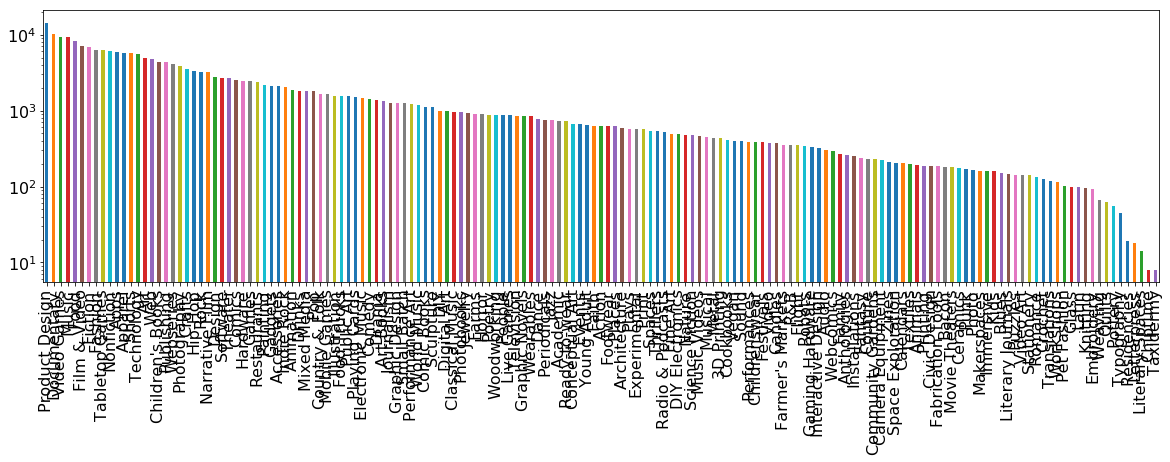

In [15]:
# 成功以外のカテゴリの分布
df_false_category = df.category[false_id]
df_false_category.value_counts().plot(kind='bar', figsize=(20,5), fontsize=16, logy=True)

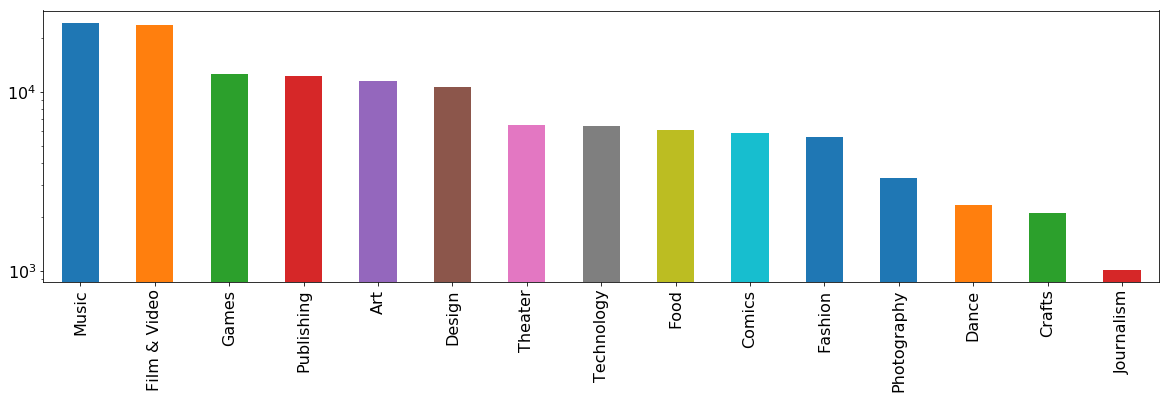

In [17]:
# 成功のメインカテゴリの分布
df_true_main_category = df.main_category[true_id]
df_true_main_category.value_counts().plot(kind='bar', figsize=(20,5), fontsize=16, logy=True)

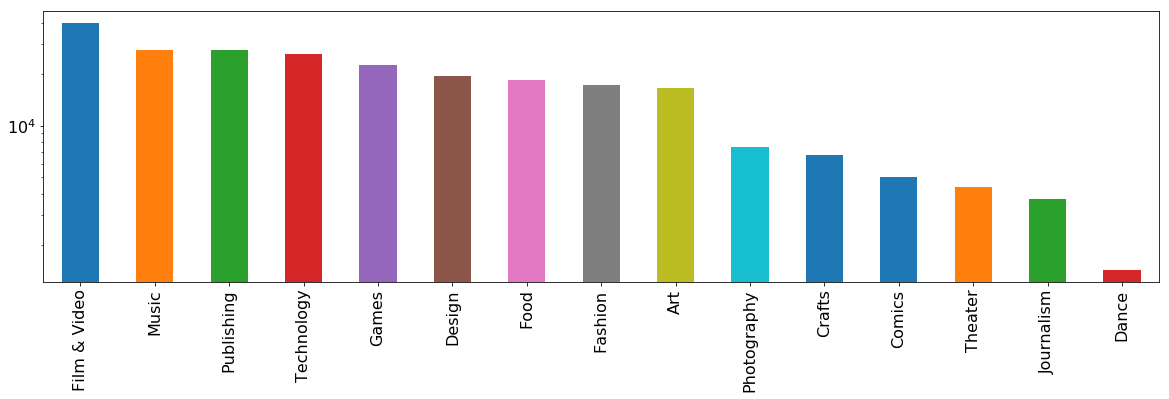

In [18]:
# 成功以外のメインカテゴリの分布
df_false_main_category = df.main_category[false_id]
df_false_main_category.value_counts().plot(kind='bar', figsize=(20,5), fontsize=16, logy=True)

In [67]:
df.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

## 数字以外を抽出

In [7]:
# type が object のカラムを抽出 & name を削除
df_obj = df.select_dtypes(include=['O']).drop('name', axis=1)
df_obj.head()

,category,main_category,currency,deadline,launched,state,country
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US
3,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US
4,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,US


In [12]:
# df の state をtrue/falseに変換
df_obj['state'] = y_bool
df_obj.head()

,category,main_category,currency,deadline,launched,state,country
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,False,GB
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,False,US
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,False,US
3,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,False,US
4,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,False,US


In [15]:
# カラムを date とカテゴリカルなカラムに分割
col_name = ['category', 'main_category', 'currency', 'country']
col_date = ['deadline', 'launched']

In [20]:
df_cat = df_obj.loc[:,col_name]
df_cat.head()

,category,main_category,currency,country
0,Poetry,Publishing,GBP,GB
1,Narrative Film,Film & Video,USD,US
2,Narrative Film,Film & Video,USD,US
3,Music,Music,USD,US
4,Film & Video,Film & Video,USD,US


In [25]:
# one hot に変換
df_one_hot = pd.get_dummies(df_cat.iloc[:,:])

In [26]:
print(df_one_hot.shape)
df_one_hot.head()

(378661, 211)


,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
# launchとdeadlineをdatetimeにする
df_date = pd.DataFrame()
for name in col_date:
    df_date[name] = pd.to_datetime(df_obj[name])

In [42]:
# launchからdeadlineまでの日数を特徴量にする
df_days = df_date[col_date[0]] - df_date[col_date[1]]
df_days.head()

0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
4   55 days 15:24:57
dtype: timedelta64[ns]

In [45]:
df_one_hot['days'] = df_days.astype('timedelta64[D]')

In [46]:
df_one_hot.head()

,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,...,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,days
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,59.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,44.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,29.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,55.0


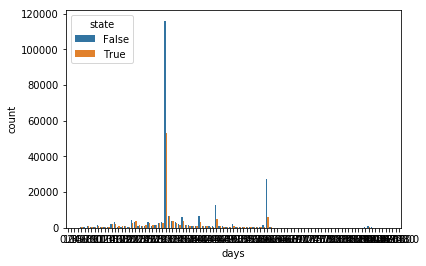

In [51]:
# days で成功or notをカウント
sns.countplot('days', hue='state', data=df_features)

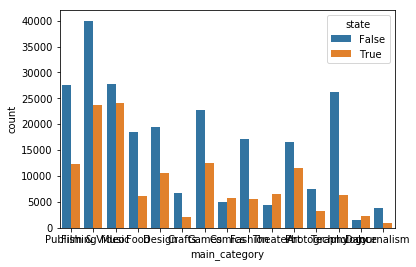

In [92]:
# main_categoryで成功or notをカウント
sns.countplot('main_category', hue='state', data=df_obj)

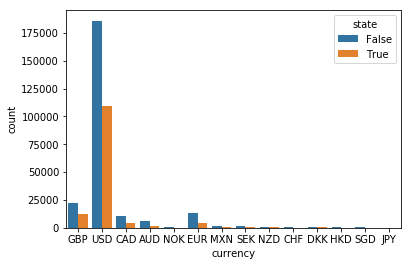

In [93]:
# currencyで成功or notをカウント
sns.countplot('currency', hue='state', data=df_obj)

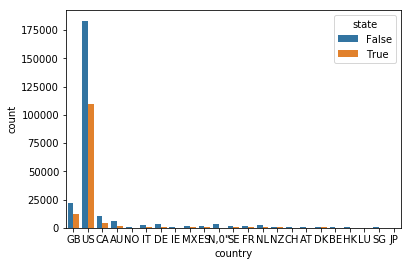

In [94]:
# country で成功or notをカウント
sns.countplot('country', hue='state', data=df_obj)

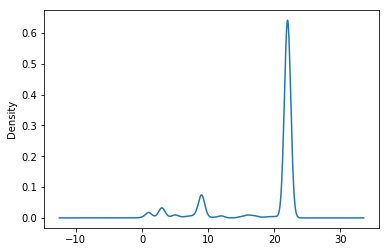

In [116]:
df_cat.country.plot.kde()

# 学習

In [56]:
# 特徴量設計済みのデータフレームを定義
df_features = pd.concat([df_one_hot, y_bool], axis=1)
df_features.head()

,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,...,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,days,state
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,58.0,False
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,59.0,False
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,44.0,False
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,29.0,False
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,55.0,False


In [57]:
# 学習用データとテスト用データに分割
np.random.seed(seed=14)
idx = df_features.index.values
train_len = int(df_features.shape[0] * 0.8)

# 分割用にランダムでインデックスをサンプリング
# 学習用データ
train_idx = random.sample(list(idx), train_len)
train_df = df_features.iloc[train_idx,:]
# テスト用データ
test_idx = list(set(df_features.index.values) ^ set(train_idx))
test_df = df_features.iloc[test_idx, :]
print(train_df.shape, test_df.shape)
print('{} + {} = {}: {}'.format(train_df.shape[0], test_df.shape[0], train_df.shape[0]+test_df.shape[0], df.shape[0]))

(302928, 213) (75733, 213)
302928 + 75733 = 378661: 378661


In [77]:
# 学習用データを説明変数と目的変数に分割
X = train_df.drop('state', axis=1).values
y = train_df.state

# 実験用にサンプリング
print('X:{} y:{}'.format(X.shape, y.shape))
train_x, train_y = X[:], y[:]
print('X:{} y:{}'.format(train_x.shape, train_y.shape))

X:(302928, 212) y:(302928,)
X:(302928, 212) y:(302928,)


In [78]:
# ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=0)
clf.fit(train_x, train_y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

# テストデータで精度算出

In [79]:
# データの整理
test_x = test_df.drop('state', axis=1).values
test_y = test_df.state

print("入力:{}, ラベル:{}".format(test_x.shape, test_y.shape))
y_est = clf.predict(test_x)

print('test_y:{}, y_est:{}'.format(test_y.shape, y_est.shape))
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(test_y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(test_y, y_est)))

入力:(75733, 212), ラベル:(75733,)
test_y:(75733,), y_est:(75733,)
対数尤度 = -11.041
正答率 = 68.034%


In [80]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(test_y, y_est), 
                        index=['正解 = 成功', '正解 = 不成功'], 
                        columns=['予測 = 成功', '予測 = 不成功'])
conf_mat

,予測 = 成功,予測 = 不成功
正解 = 成功,41411,7495
正解 = 不成功,16714,10113


In [81]:
tp, fn, fp, tn = confusion_matrix(test_y, y_est).ravel()
print(tp, fn, fp, tn)

41411 7495 16714 10113
